In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import re

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()

# Path to your log file in Google Drive
web_data = "/content/drive/My Drive/web.log"

# Read the log file as text
log_rdd = spark.sparkContext.textFile(web_data)

In [ ]:
# Custom Schema for Student
schema_student_d = StructType([
    StructField("IP_Address", StringType(), True),
    StructField("HTTP_Status_Code", IntegerType(), True),
    StructField("Response_Size", IntegerType(), True)
])

# Regex for Parsing Logs
regex_student_d = r'(\d+\.\d+\.\d+\.\d+) .*? ".*?" (\d+) (\d+|-)'

# Parse Logs and Create DataFrame
rows_student_d = log_rdd.map(lambda line: re.search(regex_student_d, line)) \
                        .filter(lambda match: match is not None) \
                        .map(lambda match: (match.group(1), int(match.group(2)), int(match.group(3))))

df_student_d = spark.createDataFrame(rows_student_d, schema=schema_student_d)

# Show the DataFrame
df_student_d.show()


+---------------+----------------+-------------+
|     IP_Address|HTTP_Status_Code|Response_Size|
+---------------+----------------+-------------+
| 88.211.105.115|             414|        12456|
|   144.6.49.142|             203|        97126|
|  231.70.64.145|             201|        33093|
| 219.42.234.172|             415|        68827|
| 183.173.185.94|             205|        30374|
|   164.12.8.113|             200|        14633|
|   110.98.7.240|             204|        63819|
| 27.182.196.243|             414|        93885|
|  123.31.25.147|             204|        75897|
|  220.182.78.75|             200|        84446|
| 206.186.128.82|             404|        24520|
| 143.238.50.180|             307|        31361|
|   12.33.251.59|             203|        37029|
| 39.107.109.242|             201|        68708|
| 250.231.144.68|             500|        69887|
| 103.105.160.60|             416|         3924|
|246.167.148.159|             500|         1685|
| 185.221.50.185|   

In [ ]:
df_student_d.createOrReplaceTempView("weblog_data_student_4")

In [ ]:
# This query identifies the IP addresses that are most likely contributing to errors by calculating their error contribution percentage and then selecting the top 10 offenders.
error_contribution_df = spark.sql("""
SELECT
    IP_Address,
    SUM(CASE WHEN HTTP_Status_Code != 200 THEN 1 ELSE 0 END) as Total_Errors,
    COUNT(*) as Total_Requests,
    (SUM(CASE WHEN HTTP_Status_Code != 200 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as Error_Contribution_Percentage
FROM weblog_data_student_4
GROUP BY IP_Address
ORDER BY Error_Contribution_Percentage DESC
LIMIT 10
""")
error_contribution_df.show()

+---------------+------------+--------------+-----------------------------+
|     IP_Address|Total_Errors|Total_Requests|Error_Contribution_Percentage|
+---------------+------------+--------------+-----------------------------+
|230.145.149.229|           1|             1|           100.00000000000000|
|  26.61.255.244|           1|             1|           100.00000000000000|
| 222.97.216.211|           1|             1|           100.00000000000000|
|  34.255.81.148|           1|             1|           100.00000000000000|
| 56.252.244.161|           1|             1|           100.00000000000000|
|  234.68.201.11|           1|             1|           100.00000000000000|
|  74.118.29.164|           1|             1|           100.00000000000000|
|  202.37.160.26|           1|             1|           100.00000000000000|
| 223.19.252.140|           1|             1|           100.00000000000000|
|   163.247.70.2|           1|             1|           100.00000000000000|
+-----------

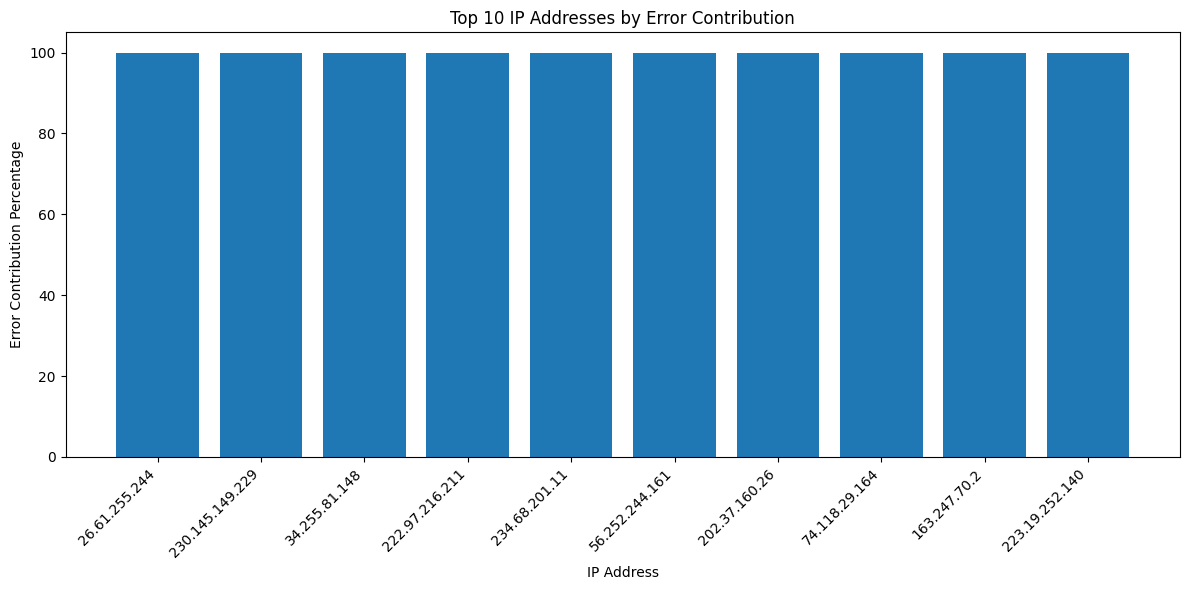

In [ ]:
pandas_df = error_contribution_df.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['IP_Address'], pandas_df['Error_Contribution_Percentage'])
plt.xlabel("IP Address")
plt.ylabel("Error Contribution Percentage")
plt.title("Top 10 IP Addresses by Error Contribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#The code identifies the IP addresses with the highest number of errors, categorized by error type, helping pinpoint potential problem areas in a web server or application.
advanced_error_analysis_df = spark.sql("""
WITH ErrorSummary AS (
    SELECT
        IP_Address,
        CASE
            WHEN HTTP_Status_Code >= 500 THEN 'Server Error'
            WHEN HTTP_Status_Code >= 400 THEN 'Client Error'
            WHEN HTTP_Status_Code >= 300 THEN 'Redirection'
            WHEN HTTP_Status_Code >= 200 THEN 'Success'
            ELSE 'Other'
        END AS Error_Category,
        COUNT(*) AS Total_Requests
    FROM weblog_data_student_4
    GROUP BY IP_Address, Error_Category
),
RankedErrors AS (
    SELECT
        IP_Address,
        Error_Category,
        Total_Requests,
        RANK() OVER (PARTITION BY IP_Address ORDER BY Total_Requests DESC) AS Error_Rank
    FROM ErrorSummary
)
SELECT
    re.IP_Address,
    re.Error_Category,
    re.Total_Requests,
    es.Total_Requests AS Total_Requests_For_IP
FROM RankedErrors re
JOIN ErrorSummary es ON re.IP_Address = es.IP_Address
WHERE re.Error_Rank = 1
ORDER BY re.Total_Requests DESC
LIMIT 10
""")
advanced_error_analysis_df.show()

+---------------+--------------+--------------+---------------------+
|     IP_Address|Error_Category|Total_Requests|Total_Requests_For_IP|
+---------------+--------------+--------------+---------------------+
|    1.4.140.204|       Success|             2|                    2|
|  1.194.139.212|   Redirection|             2|                    2|
|220.142.249.162|  Client Error|             2|                    2|
| 111.201.18.173|       Success|             2|                    2|
| 115.215.98.170|       Success|             2|                    2|
|     1.57.49.51|  Server Error|             2|                    2|
| 255.74.196.154|   Redirection|             2|                    2|
|  102.146.8.125|  Client Error|             2|                    2|
|  10.175.188.46|       Success|             2|                    2|
|  103.60.160.21|       Success|             2|                    2|
+---------------+--------------+--------------+---------------------+



In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
pandas_df = advanced_error_analysis_df.toPandas()

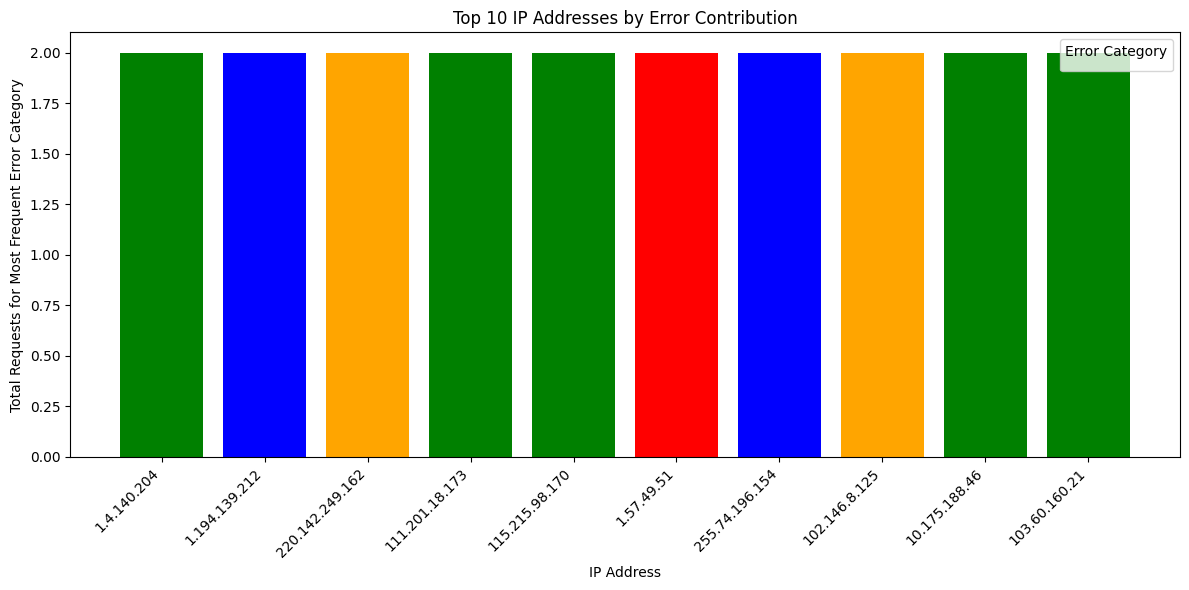

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['IP_Address'], pandas_df['Total_Requests'], color=pandas_df['Error_Category'].map({'Server Error': 'red', 'Client Error': 'orange', 'Redirection': 'blue', 'Success': 'green', 'Other': 'gray'}))
plt.xlabel("IP Address")
plt.ylabel("Total Requests for Most Frequent Error Category")
plt.title("Top 10 IP Addresses by Error Contribution")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Error Category")
plt.tight_layout()
plt.show()

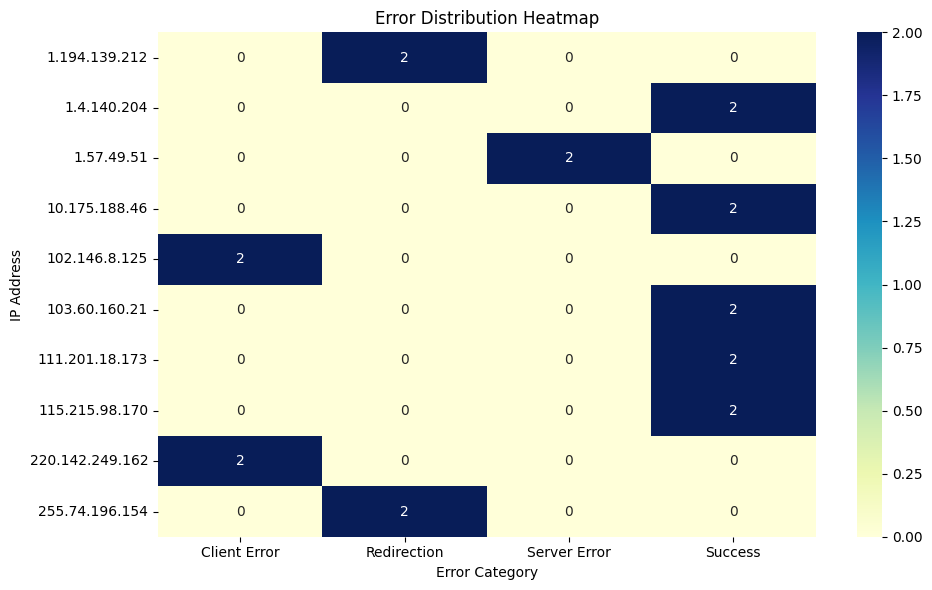

In [ ]:
import seaborn as sns

heatmap_data = pandas_df.pivot(index='IP_Address', columns='Error_Category', values='Total_Requests').fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.xlabel("Error Category")
plt.ylabel("IP Address")
plt.title("Error Distribution Heatmap")
plt.tight_layout()
plt.show()

Parse log entries to extract IP Address, Timestamp, and URL.
Filter logs to keep only unique combinations of IP Address and URL.
Count the number of such unique combinations.

In [ ]:
# Parse log entries for Student
def parse_log_student_4(line):
    try:
        regex = r'(\d+\.\d+\.\d+\.\d+) .*? \[(.*?)\] ".*? (.*?) HTTP/.*?"'
        match = re.search(regex, line)
        if match:
            ip = match.group(1)
            timestamp = match.group(2)
            url = match.group(3)
            return ip, timestamp, url
    except:
        return None

# Parse logs
parsed_rdd_student_4 = log_rdd.map(parse_log_student_4).filter(lambda x: x is not None)

# Basic RDD Transformation + Action: Count unique combinations of IP and URL
unique_ip_url_rdd = parsed_rdd_student_4.map(lambda x: (x[0], x[2])).distinct()
unique_ip_url_count = unique_ip_url_rdd.count()

print(f"Number of Unique IP-URL Combinations: {unique_ip_url_count}")


Number of Unique IP-URL Combinations: 2000644


Query 1: Count unique IPs per URL.
Query 2: Identify top 5 URLs with the most unique IPs.

In [ ]:
# Query 1: Unique IPs Per URL
unique_ips_per_url_rdd = parsed_rdd_student_4.map(lambda x: (x[2], x[0])).distinct() \
                                             .map(lambda x: (x[0], 1)) \
                                             .reduceByKey(lambda a, b: a + b)

print("Unique IP Counts Per URL:")
for url, unique_ips in unique_ips_per_url_rdd.take(10):
    print(f"URL: {url}, Unique IPs: {unique_ips}")

# Query 2: Top 5 URLs with Most Unique IPs
top_urls_by_unique_ips = unique_ips_per_url_rdd.takeOrdered(5, key=lambda x: -x[1])

print("Top 5 URLs by Unique IP Counts:")
for url, unique_ips in top_urls_by_unique_ips:
    print(f"URL: {url}, Unique IPs: {unique_ips}")


Unique IP Counts Per URL:
URL: /security/launch/, Unique IPs: 16542
URL: /shuttle/data/, Unique IPs: 16700
URL: /security/firewall/, Unique IPs: 16677
URL: /software/data/, Unique IPs: 16955
URL: /machine-learning/apollo-11/, Unique IPs: 16638
URL: /web-development/firewall/, Unique IPs: 16559
URL: /images/apollo-11/, Unique IPs: 16713
URL: /images/firewall/, Unique IPs: 16577
URL: /history/apollo-11/, Unique IPs: 16395
URL: /web-development/deep-learning/, Unique IPs: 16780
Top 5 URLs by Unique IP Counts:
URL: /software/data/, Unique IPs: 16955
URL: /web-development/missions/, Unique IPs: 16946
URL: /software/technology/, Unique IPs: 16928
URL: /security/technology/, Unique IPs: 16921
URL: /data-analysis/technology/, Unique IPs: 16919


Partition Strategy Analysis
The advanced_partition_strategies function evaluates the effectiveness of four partitioning methods using an RDD. The default partitioning relies on Spark's default mechanism, providing a baseline for comparison. IP-based partitioning divides records into 5 partitions using the first two octets of the IP address, balancing network-related data across partitions. Timestamp-based partitioning groups data by the hour extracted from the timestamp, enabling efficient temporal analysis. Finally, URL domain partitioning partitions records by the domain part of the URL, optimizing operations for specific domain-based queries. Each strategy assesses the number of partitions and the record count, illustrating how different partitioning keys impact data distribution and parallel processing.

Caching Performance Analysis
The caching_performance_analysis function measures the performance impact of caching RDDs and DataFrames in Spark. For RDDs, the function computes unique IP counts and reduces URL frequencies with and without caching. Caching significantly reduces execution time by storing intermediate results in memory, as demonstrated by faster unique IP computations and top URL queries. Additionally, a DataFrame-based analysis is performed, comparing execution times for operations like counting distinct IPs with and without caching. Both RDD and DataFrame analyses highlight how caching eliminates redundant computations, enhances efficiency for iterative workloads, and improves performance for large-scale data processing tasks.

In [ ]:
import re
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, spark_partition_id, countDistinct

def advanced_partition_strategies(parsed_rdd):
    """
    Comprehensive exploration of partition strategies

    Strategies:
    1. Default Partitioning
    2. IP-based Partitioning
    3. Timestamp-based Partitioning
    4. URL Domain Partitioning
    """
    # Strategy 1: Default Partitioning
    default_rdd = parsed_rdd
    default_partition_count = default_rdd.getNumPartitions()
    default_record_count = default_rdd.count()

    # Strategy 2: IP-based Partitioning
    def ip_partition_key(item):
        # Use first two octets of IP for partitioning
        return hash('.'.join(item[0].split('.')[:2])) % 5

    ip_partitioned_rdd = parsed_rdd.map(lambda x: (ip_partition_key(x), x))
    ip_partition_count = ip_partitioned_rdd.getNumPartitions()
    ip_record_count = ip_partitioned_rdd.count()

    # Strategy 3: Timestamp-based Partitioning
    def timestamp_partition_key(item):
        # Partition by hour of the day
        return hash(item[1].split(':')[1]) % 4

    timestamp_partitioned_rdd = parsed_rdd.map(lambda x: (timestamp_partition_key(x), x))
    timestamp_partition_count = timestamp_partitioned_rdd.getNumPartitions()
    timestamp_record_count = timestamp_partitioned_rdd.count()

    # Strategy 4: URL Domain Partitioning
    def url_domain_partition_key(item):
        # Simple domain partitioning
        return hash(item[2].split('/')[0]) % 3

    url_partitioned_rdd = parsed_rdd.map(lambda x: (url_domain_partition_key(x), x))
    url_partition_count = url_partitioned_rdd.getNumPartitions()
    url_record_count = url_partitioned_rdd.count()

    return {
        "Default Partitioning": {
            "Partitions": default_partition_count,
            "Record Count": default_record_count
        },
        "IP-based Partitioning": {
            "Partitions": ip_partition_count,
            "Record Count": ip_record_count
        },
        "Timestamp Partitioning": {
            "Partitions": timestamp_partition_count,
            "Record Count": timestamp_record_count
        },
        "URL Domain Partitioning": {
            "Partitions": url_partition_count,
            "Record Count": url_record_count
        }
    }

def caching_performance_analysis(parsed_rdd):
    """
    Comprehensive analysis of caching performance

    Compares:
    1. Execution time without caching
    2. Execution time with caching
    3. Computational complexity
    """
    # Performance analysis for unique IP count
    start_time_no_cache = time.time()
    no_cache_unique_ips = parsed_rdd.map(lambda x: x[0]).distinct().count()
    no_cache_url_counts = parsed_rdd.map(lambda x: (x[2], 1)).reduceByKey(lambda a, b: a + b)
    no_cache_top_urls = no_cache_url_counts.takeOrdered(5, key=lambda x: -x[1])
    no_cache_time = time.time() - start_time_no_cache

    # Caching Performance
    cached_rdd = parsed_rdd.cache()
    start_time_cached = time.time()
    cached_unique_ips = cached_rdd.map(lambda x: x[0]).distinct().count()
    cached_url_counts = cached_rdd.map(lambda x: (x[2], 1)).reduceByKey(lambda a, b: a + b)
    cached_top_urls = cached_url_counts.takeOrdered(5, key=lambda x: -x[1])
    cached_time = time.time() - start_time_cached

    # Advanced Caching Analysis with DataFrame
    spark = SparkSession.builder.getOrCreate()
    df = spark.createDataFrame(parsed_rdd, ["ip", "timestamp", "url"])

    start_time_df_no_cache = time.time()
    df_no_cache_unique = df.select(countDistinct("ip")).collect()[0][0]
    df_no_cache_time = time.time() - start_time_df_no_cache

    cached_df = df.cache()
    start_time_df_cached = time.time()
    df_cached_unique = cached_df.select(countDistinct("ip")).collect()[0][0]
    df_cached_time = time.time() - start_time_df_cached

    return {
        "RDD Analysis": {
            "No Cache": {
                "Unique IPs": no_cache_unique_ips,
                "Execution Time": no_cache_time,
                "Top 5 URLs": no_cache_top_urls
            },
            "Cached": {
                "Unique IPs": cached_unique_ips,
                "Execution Time": cached_time,
                "Top 5 URLs": cached_top_urls
            }
        },
        "DataFrame Analysis": {
            "No Cache": {
                "Unique IPs": df_no_cache_unique,
                "Execution Time": df_no_cache_time
            },
            "Cached": {
                "Unique IPs": df_cached_unique,
                "Execution Time": df_cached_time
            }
        }
    }

def main():
    # Partition Strategy Analysis
    partition_results = advanced_partition_strategies(parsed_rdd_student_4)
    print("Partition Strategy Analysis:")
    for strategy, results in partition_results.items():
        print(f"\n{strategy}:")
        print(f"  Partitions: {results['Partitions']}")
        print(f"  Record Count: {results['Record Count']}")

    # Caching Performance Analysis
    caching_results = caching_performance_analysis(parsed_rdd_student_4)
    print("\nCaching Performance Analysis:")

    print("\nRDD Caching Analysis:")
    for cache_type, results in caching_results["RDD Analysis"].items():
        print(f"\n{cache_type} Strategy:")
        print(f"  Unique IPs: {results['Unique IPs']}")
        print(f"  Execution Time: {results['Execution Time']:.4f} seconds")
        if 'Top 5 URLs' in results:
            print("  Top 5 URLs:")
            for url, count in results['Top 5 URLs']:
                print(f"    {url}: {count}")

    print("\nDataFrame Caching Analysis:")
    for cache_type, results in caching_results["DataFrame Analysis"].items():
        print(f"\n{cache_type} Strategy:")
        print(f"  Unique IPs: {results['Unique IPs']}")
        print(f"  Execution Time: {results['Execution Time']:.4f} seconds")

if __name__ == "__main__":
    main()

Partition Strategy Analysis:

Default Partitioning:
  Partitions: 13
  Record Count: 2000652

IP-based Partitioning:
  Partitions: 13
  Record Count: 2000652

Timestamp Partitioning:
  Partitions: 13
  Record Count: 2000652

URL Domain Partitioning:
  Partitions: 13
  Record Count: 2000652

Caching Performance Analysis:

RDD Caching Analysis:

No Cache Strategy:
  Unique IPs: 2000160
  Execution Time: 180.0736 seconds
  Top 5 URLs:
    /software/data/: 16955
    /web-development/missions/: 16946
    /software/technology/: 16928
    /security/technology/: 16921
    /data-analysis/technology/: 16919

Cached Strategy:
  Unique IPs: 2000160
  Execution Time: 104.1230 seconds
  Top 5 URLs:
    /software/data/: 16955
    /web-development/missions/: 16946
    /software/technology/: 16928
    /security/technology/: 16921
    /data-analysis/technology/: 16919

DataFrame Caching Analysis:

No Cache Strategy:
  Unique IPs: 2000160
  Execution Time: 18.0079 seconds

Cached Strategy:
  Unique IPs: 

In [ ]:
# install nbconvert
#!pip3 install nbconvert

!jupyter nbconvert --to html weblog_data_analysis.ipynb